# topic-grid

Create a grid that represents the fit between a natural language client question and a research document. The fit can be quantified using any method we choose that is tested and robust. 

In [1]:
# Initialize with basic packages
%run include-2-shared-functions.ipynb

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


/home/jsub10/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

/home/jsub10/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


In [166]:
#### DATA GENERATION PARAMETERS ####

# Set the number of questions and the number of research documents
NUM_QUESTIONS = 50
NUM_DOCS = 100

# Set up some ranges
dict_ranges = {'low': [0,0.25], 'med': [0.25,0.5], 'high': [0.5,0.75], 'vhigh': [0.75,1]}

# Threshold value for determining whether demand fits supply
FIT = 0.7 # anything equal or greater than FIT will count as demand satisfying supply

In [167]:
def generate_grid(ranges, num_q, num_docs):
    '''
    Generate a topic grid. Each row of the topic grid is a list of numbers, each number between 0 and 1. 
    Each row stands for a question. The numbers in the row represent the documents -- each number is a measure of the how well the document "fits" the question.
    Fit can be quantified in any way you choose -- when a document fit is high it means the document answers that question well. 
    
    num_q specifies the number of questions -- the number of rows in the grid. 
    num_docs specifies the number of documents -- the number of columns in the grid.
    
    USES constrained_sum_sample_pos in include-2-shared-functions
    
    '''
    # Want each row to be random but not uniformly random. To do this, let's randomize 
    ## how many low, medium, and high values we want in the row. 
    # Get the num of ranges we have in ranges
    num_ranges = len(ranges)
    # For each range get the number of values to generate
    grid_lists = []
    for i in range(num_q):
        # Create the number of values to generate in each range
        nums_in_range = constrained_sum_sample_pos(num_ranges, num_docs)
        partial_rows = []
        for j in range(len(nums_in_range)):
            partial_row = [round(random.uniform(list(ranges.values())[j][0],list(ranges.values())[j][1]), 2) for k in range(nums_in_range[j])]
            partial_rows.append(partial_row)
        # A separate list for each range is now created
        ## Combine those separate lists into one single list to create the row
        row = flatten_list(partial_rows)
        # To keep the order of the low, medium, and high values unpredictable, shuffle the row
        random.shuffle(row)
        grid_lists.append(row)
        
    # The grid lists are now created
    ## Turn it into a dataframe
    column_names = ['Doc ' + str(i+1) for i in range(num_docs)]
    row_idx = ['Q' + str(i+1) for i in range(num_q)]
    df_grid = pd.DataFrame(grid_lists)
    df_grid.columns = column_names
    df_grid.index = row_idx
    
    return df_grid
    

In [168]:
df_grid = generate_grid(ranges=dict_ranges, num_q=NUM_QUESTIONS, num_docs=NUM_DOCS)
df_grid

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18,Doc 19,Doc 20,Doc 21,Doc 22,Doc 23,Doc 24,Doc 25,Doc 26,Doc 27,Doc 28,Doc 29,Doc 30,Doc 31,Doc 32,Doc 33,Doc 34,Doc 35,Doc 36,Doc 37,Doc 38,Doc 39,Doc 40,Doc 41,Doc 42,Doc 43,Doc 44,Doc 45,Doc 46,Doc 47,Doc 48,Doc 49,Doc 50,Doc 51,Doc 52,Doc 53,Doc 54,Doc 55,Doc 56,Doc 57,Doc 58,Doc 59,Doc 60,Doc 61,Doc 62,Doc 63,Doc 64,Doc 65,Doc 66,Doc 67,Doc 68,Doc 69,Doc 70,Doc 71,Doc 72,Doc 73,Doc 74,Doc 75,Doc 76,Doc 77,Doc 78,Doc 79,Doc 80,Doc 81,Doc 82,Doc 83,Doc 84,Doc 85,Doc 86,Doc 87,Doc 88,Doc 89,Doc 90,Doc 91,Doc 92,Doc 93,Doc 94,Doc 95,Doc 96,Doc 97,Doc 98,Doc 99,Doc 100
Q1,0.59,0.55,0.73,0.78,0.38,0.47,0.49,0.39,0.87,0.84,0.98,0.52,1.00,0.26,0.60,0.73,0.87,0.97,0.67,0.90,0.49,0.84,0.38,0.77,0.55,0.65,0.80,0.46,0.51,0.42,0.66,0.86,0.42,0.59,0.34,0.96,0.43,0.37,0.86,0.53,0.33,0.46,0.45,0.93,0.46,0.88,0.73,0.39,0.59,0.30,0.59,0.88,0.48,0.29,0.45,0.66,0.84,0.54,0.51,0.36,0.40,0.94,0.25,0.27,0.08,0.34,0.30,0.47,0.53,0.57,0.32,0.97,0.36,0.80,0.35,0.81,0.53,0.48,0.61,0.89,0.59,0.35,0.52,0.38,0.83,0.72,0.86,0.82,0.64,0.84,0.37,0.52,0.60,0.38,0.45,0.36,0.73,0.20,0.67,0.60
Q2,0.05,0.73,0.55,0.07,0.67,0.90,0.56,0.12,0.21,0.04,0.07,0.90,0.79,0.18,0.15,0.85,0.20,0.96,0.63,0.92,0.73,0.62,0.68,0.46,0.95,0.02,0.49,0.65,0.89,0.25,0.67,0.25,0.41,0.71,0.64,0.99,0.15,0.97,0.96,0.70,0.63,0.89,0.63,0.11,0.48,0.74,0.97,0.60,0.57,0.24,0.06,0.22,0.56,0.94,0.58,0.21,0.68,0.86,0.58,0.55,0.71,0.21,0.38,0.54,0.91,0.58,0.39,0.87,0.12,0.49,0.27,0.68,0.38,0.14,0.68,0.73,0.14,0.33,0.83,0.76,0.61,0.06,0.01,0.49,0.53,0.82,0.62,0.56,0.90,0.70,0.73,0.68,0.69,0.41,0.13,0.62,0.75,0.73,0.68,0.25
Q3,0.37,0.57,0.94,0.89,0.75,0.65,0.74,0.74,0.36,0.90,0.76,0.99,0.95,0.57,0.91,0.83,0.97,0.87,0.81,0.65,0.90,0.71,0.53,0.53,0.92,0.97,0.77,0.66,0.91,0.68,0.94,0.84,0.83,0.93,0.88,0.84,0.59,0.90,0.45,0.82,0.91,0.96,0.57,0.54,0.92,0.74,0.84,0.83,0.84,0.79,0.92,0.94,0.79,0.86,0.94,0.97,0.70,0.52,0.41,0.55,0.90,0.79,0.86,0.89,0.92,0.97,0.92,0.05,0.76,0.72,0.80,0.44,0.81,0.99,0.97,0.81,0.76,0.88,0.76,0.80,0.85,0.81,0.94,0.78,0.85,0.87,0.81,0.88,0.98,0.84,0.73,0.38,0.81,0.75,0.83,0.81,0.96,0.79,0.07,0.96
Q4,0.66,0.57,0.66,0.39,0.63,0.79,0.58,0.40,0.45,0.57,0.81,0.43,0.22,0.46,0.25,0.41,0.34,0.32,0.54,0.07,0.48,0.32,0.60,0.40,0.73,0.61,0.13,0.18,0.86,0.78,0.33,0.33,0.48,0.49,0.29,0.36,0.71,0.43,0.67,0.48,0.68,0.54,0.30,0.31,0.35,0.34,0.57,0.28,0.45,0.54,0.38,0.54,0.59,0.63,0.54,0.67,0.54,0.44,0.26,0.23,0.31,0.39,0.42,0.79,0.32,0.73,0.49,0.44,0.48,0.69,0.68,0.56,0.29,0.30,0.38,0.41,0.42,0.69,0.39,0.45,0.66,0.52,0.10,0.81,0.87,0.47,0.62,0.31,0.91,0.39,0.66,0.30,0.11,0.28,0.33,0.98,0.43,0.31,0.25,0.35
Q5,0.51,0.60,0.83,0.80,0.26,0.99,0.82,0.91,0.81,0.94,0.45,0.89,0.80,0.55,0.99,0.79,0.85,0.34,0.69,0.70,0.79,0.70,0.94,0.71,0.66,0.84,0.82,0.48,0.85,0.85,0.25,0.73,0.86,0.95,0.47,0.32,0.78,0.98,0.62,0.30,0.77,0.91,0.87,0.41,0.95,0.89,0.88,0.70,0.55,0.53,0.93,0.28,0.99,0.90,0.66,0.54,0.80,0.63,0.58,0.56,0.75,0.64,0.38,0.86,0.80,0.84,0.19,0.42,0.89,0.91,0.54,0.37,0.53,0.68,0.87,0.85,0.98,0.13,0.51,0.72,0.57,0.44,0.32,0.66,0.60,0.68,0.92,1.00,0.90,0.41,0.87,0.90,0.77,0.39,0.72,0.77,0.51,0.90,0.45,0.58
Q6,0.21,0.27,0.17,0.13,0.57,0.14,0.02,0.66,0.59,0.67,0.93,0.08,0.68,0.55,0.21,0.04,0.11,0.02,0.02,0.87,0.23,0.37,0.07,0.58,0.51,0.52,0.12,0.29,0.42,0.25,0.05,0.10,0.51,0.85,0.82,0.83,0.08,0.49,0.36,0.59,0.09,0.35,0.63,0.10,0.17,0.24,0.05,0.41,0.10,0.23,0.13,0.21,0.09,0.41,0.40,0.11,0.72,0.21,0.50,0.68,0.44,0.21,0.99,0.01,0.25,0.04,0.12,0.41,0.08,0.29,0.69,0.02,0.52,0.15,0.49,0.14,0.78,0.45,0.36,0.07,0.71,0.42,0.59,0.68,0.19,0.01,0.07,0.16,0.53,0.16,0.30,0.92,0.73,0.72,0.09,0.79,0.93,0.38,0.25,0.55
Q7,0.41,0.33,0.59,0.17,0.95,0.65,0.26,0.43,0.28,0.51,0.75,0.07,0.74,0.65,0.61,0.35,0.55,0.73,0.31,0.93,0.62,1.00,0.60,0.21,0.47,0.55,0.71,0.72,0.13,0.67,0.60,0.58,0.51,0.65,0.63,0.65,0.01,0.45,0.63,0.68,0.57,0.74,0.68,0.89,0.73,0.85,0.64,0.60,0.60,0.38,0.67,0.37,0.44,0.66,0.10,0.70,0.27,0

In [169]:
def grid_stats(df_grid, fit_thresh):
    '''
    Calculate the coverage of each question/topic across the documents (Demand Covered by Supply) and
    the coverage of each document across the questions (Supply Covered by Demand). 
    
    df_grid is the output of the generate_grid function
    fit_thresh is the fitness floor set in the FIT constant
    
    '''
    # For each row of df_grid, calculate the percentage of documents that fit the question
    row_percentages = []
    
    for i in range(len(df_grid)):
        row_vals = df_grid.iloc[i,:].values
        # Row values and ids that are greater than the fit_thresh
        row_vals_above = [[idx, val] for idx,val in enumerate(row_vals) if val >= fit_thresh]
        num_row_vals_above = len([x[1] for x in row_vals_above])
        row_percentage = round((num_row_vals_above/len(row_vals))*100, 0)
        row_percentages.append(row_percentage)
        
    # For each column of df_grid, calculate the percentage of questions that fit the document
    col_percentages = []
    for i in range(df_grid.shape[1]):
        col_vals = df_grid.iloc[:,i].values
        col_vals_above = [[idx, val] for idx,val in enumerate(col_vals) if val >= fit_thresh]
        num_col_vals_above = len([x[1] for x in col_vals_above])
        col_percentage = round((num_col_vals_above/len(col_vals))*100, 0)
        col_percentages.append(col_percentage)
    
    
    # Add a column to df_grid with the row_percentages
    df1 = df_grid.copy()
    df1['% Docs With Good Coverage of Question'] = row_percentages
    
    # Add a row to df1 with the col_percentages
    df2 = pd.DataFrame(columns=list(df1))
    df2.loc[0] = col_percentages + [0]
    df2.index = ['% Questions Covered Well By Document']
    
    df_out = pd.concat([df1, df2])
    
    dict_out = {'df_out': df_out, 
                'row_vals_above': row_vals_above,
                'row_percentages': row_percentages,
                'col_vals_above': col_vals_above, 
                'col_percentages': col_percentages
               }
    
    return dict_out
        

In [170]:
df_grid

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18,Doc 19,Doc 20,Doc 21,Doc 22,Doc 23,Doc 24,Doc 25,Doc 26,Doc 27,Doc 28,Doc 29,Doc 30,Doc 31,Doc 32,Doc 33,Doc 34,Doc 35,Doc 36,Doc 37,Doc 38,Doc 39,Doc 40,Doc 41,Doc 42,Doc 43,Doc 44,Doc 45,Doc 46,Doc 47,Doc 48,Doc 49,Doc 50,Doc 51,Doc 52,Doc 53,Doc 54,Doc 55,Doc 56,Doc 57,Doc 58,Doc 59,Doc 60,Doc 61,Doc 62,Doc 63,Doc 64,Doc 65,Doc 66,Doc 67,Doc 68,Doc 69,Doc 70,Doc 71,Doc 72,Doc 73,Doc 74,Doc 75,Doc 76,Doc 77,Doc 78,Doc 79,Doc 80,Doc 81,Doc 82,Doc 83,Doc 84,Doc 85,Doc 86,Doc 87,Doc 88,Doc 89,Doc 90,Doc 91,Doc 92,Doc 93,Doc 94,Doc 95,Doc 96,Doc 97,Doc 98,Doc 99,Doc 100
Q1,0.59,0.55,0.73,0.78,0.38,0.47,0.49,0.39,0.87,0.84,0.98,0.52,1.00,0.26,0.60,0.73,0.87,0.97,0.67,0.90,0.49,0.84,0.38,0.77,0.55,0.65,0.80,0.46,0.51,0.42,0.66,0.86,0.42,0.59,0.34,0.96,0.43,0.37,0.86,0.53,0.33,0.46,0.45,0.93,0.46,0.88,0.73,0.39,0.59,0.30,0.59,0.88,0.48,0.29,0.45,0.66,0.84,0.54,0.51,0.36,0.40,0.94,0.25,0.27,0.08,0.34,0.30,0.47,0.53,0.57,0.32,0.97,0.36,0.80,0.35,0.81,0.53,0.48,0.61,0.89,0.59,0.35,0.52,0.38,0.83,0.72,0.86,0.82,0.64,0.84,0.37,0.52,0.60,0.38,0.45,0.36,0.73,0.20,0.67,0.60
Q2,0.05,0.73,0.55,0.07,0.67,0.90,0.56,0.12,0.21,0.04,0.07,0.90,0.79,0.18,0.15,0.85,0.20,0.96,0.63,0.92,0.73,0.62,0.68,0.46,0.95,0.02,0.49,0.65,0.89,0.25,0.67,0.25,0.41,0.71,0.64,0.99,0.15,0.97,0.96,0.70,0.63,0.89,0.63,0.11,0.48,0.74,0.97,0.60,0.57,0.24,0.06,0.22,0.56,0.94,0.58,0.21,0.68,0.86,0.58,0.55,0.71,0.21,0.38,0.54,0.91,0.58,0.39,0.87,0.12,0.49,0.27,0.68,0.38,0.14,0.68,0.73,0.14,0.33,0.83,0.76,0.61,0.06,0.01,0.49,0.53,0.82,0.62,0.56,0.90,0.70,0.73,0.68,0.69,0.41,0.13,0.62,0.75,0.73,0.68,0.25
Q3,0.37,0.57,0.94,0.89,0.75,0.65,0.74,0.74,0.36,0.90,0.76,0.99,0.95,0.57,0.91,0.83,0.97,0.87,0.81,0.65,0.90,0.71,0.53,0.53,0.92,0.97,0.77,0.66,0.91,0.68,0.94,0.84,0.83,0.93,0.88,0.84,0.59,0.90,0.45,0.82,0.91,0.96,0.57,0.54,0.92,0.74,0.84,0.83,0.84,0.79,0.92,0.94,0.79,0.86,0.94,0.97,0.70,0.52,0.41,0.55,0.90,0.79,0.86,0.89,0.92,0.97,0.92,0.05,0.76,0.72,0.80,0.44,0.81,0.99,0.97,0.81,0.76,0.88,0.76,0.80,0.85,0.81,0.94,0.78,0.85,0.87,0.81,0.88,0.98,0.84,0.73,0.38,0.81,0.75,0.83,0.81,0.96,0.79,0.07,0.96
Q4,0.66,0.57,0.66,0.39,0.63,0.79,0.58,0.40,0.45,0.57,0.81,0.43,0.22,0.46,0.25,0.41,0.34,0.32,0.54,0.07,0.48,0.32,0.60,0.40,0.73,0.61,0.13,0.18,0.86,0.78,0.33,0.33,0.48,0.49,0.29,0.36,0.71,0.43,0.67,0.48,0.68,0.54,0.30,0.31,0.35,0.34,0.57,0.28,0.45,0.54,0.38,0.54,0.59,0.63,0.54,0.67,0.54,0.44,0.26,0.23,0.31,0.39,0.42,0.79,0.32,0.73,0.49,0.44,0.48,0.69,0.68,0.56,0.29,0.30,0.38,0.41,0.42,0.69,0.39,0.45,0.66,0.52,0.10,0.81,0.87,0.47,0.62,0.31,0.91,0.39,0.66,0.30,0.11,0.28,0.33,0.98,0.43,0.31,0.25,0.35
Q5,0.51,0.60,0.83,0.80,0.26,0.99,0.82,0.91,0.81,0.94,0.45,0.89,0.80,0.55,0.99,0.79,0.85,0.34,0.69,0.70,0.79,0.70,0.94,0.71,0.66,0.84,0.82,0.48,0.85,0.85,0.25,0.73,0.86,0.95,0.47,0.32,0.78,0.98,0.62,0.30,0.77,0.91,0.87,0.41,0.95,0.89,0.88,0.70,0.55,0.53,0.93,0.28,0.99,0.90,0.66,0.54,0.80,0.63,0.58,0.56,0.75,0.64,0.38,0.86,0.80,0.84,0.19,0.42,0.89,0.91,0.54,0.37,0.53,0.68,0.87,0.85,0.98,0.13,0.51,0.72,0.57,0.44,0.32,0.66,0.60,0.68,0.92,1.00,0.90,0.41,0.87,0.90,0.77,0.39,0.72,0.77,0.51,0.90,0.45,0.58
Q6,0.21,0.27,0.17,0.13,0.57,0.14,0.02,0.66,0.59,0.67,0.93,0.08,0.68,0.55,0.21,0.04,0.11,0.02,0.02,0.87,0.23,0.37,0.07,0.58,0.51,0.52,0.12,0.29,0.42,0.25,0.05,0.10,0.51,0.85,0.82,0.83,0.08,0.49,0.36,0.59,0.09,0.35,0.63,0.10,0.17,0.24,0.05,0.41,0.10,0.23,0.13,0.21,0.09,0.41,0.40,0.11,0.72,0.21,0.50,0.68,0.44,0.21,0.99,0.01,0.25,0.04,0.12,0.41,0.08,0.29,0.69,0.02,0.52,0.15,0.49,0.14,0.78,0.45,0.36,0.07,0.71,0.42,0.59,0.68,0.19,0.01,0.07,0.16,0.53,0.16,0.30,0.92,0.73,0.72,0.09,0.79,0.93,0.38,0.25,0.55
Q7,0.41,0.33,0.59,0.17,0.95,0.65,0.26,0.43,0.28,0.51,0.75,0.07,0.74,0.65,0.61,0.35,0.55,0.73,0.31,0.93,0.62,1.00,0.60,0.21,0.47,0.55,0.71,0.72,0.13,0.67,0.60,0.58,0.51,0.65,0.63,0.65,0.01,0.45,0.63,0.68,0.57,0.74,0.68,0.89,0.73,0.85,0.64,0.60,0.60,0.38,0.67,0.37,0.44,0.66,0.10,0.70,0.27,0

In [171]:
dict_out = grid_stats(df_grid, fit_thresh=FIT)

In [172]:
dict_out['df_out']

,Doc 1,Doc 2,Doc 3,Doc 4,Doc 5,Doc 6,Doc 7,Doc 8,Doc 9,Doc 10,Doc 11,Doc 12,Doc 13,Doc 14,Doc 15,Doc 16,Doc 17,Doc 18,Doc 19,Doc 20,Doc 21,Doc 22,Doc 23,Doc 24,Doc 25,Doc 26,Doc 27,Doc 28,Doc 29,Doc 30,Doc 31,Doc 32,Doc 33,Doc 34,Doc 35,Doc 36,Doc 37,Doc 38,Doc 39,Doc 40,Doc 41,Doc 42,Doc 43,Doc 44,Doc 45,Doc 46,Doc 47,Doc 48,Doc 49,Doc 50,Doc 51,Doc 52,Doc 53,Doc 54,Doc 55,Doc 56,Doc 57,Doc 58,Doc 59,Doc 60,Doc 61,Doc 62,Doc 63,Doc 64,Doc 65,Doc 66,Doc 67,Doc 68,Doc 69,Doc 70,Doc 71,Doc 72,Doc 73,Doc 74,Doc 75,Doc 76,Doc 77,Doc 78,Doc 79,Doc 80,Doc 81,Doc 82,Doc 83,Doc 84,Doc 85,Doc 86,Doc 87,Doc 88,Doc 89,Doc 90,Doc 91,Doc 92,Doc 93,Doc 94,Doc 95,Doc 96,Doc 97,Doc 98,Doc 99,Doc 100,% Docs With Good Coverage of Question
Q1,0.59,0.55,0.73,0.78,0.38,0.47,0.49,0.39,0.87,0.84,0.98,0.52,1.00,0.26,0.60,0.73,0.87,0.97,0.67,0.90,0.49,0.84,0.38,0.77,0.55,0.65,0.80,0.46,0.51,0.42,0.66,0.86,0.42,0.59,0.34,0.96,0.43,0.37,0.86,0.53,0.33,0.46,0.45,0.93,0.46,0.88,0.73,0.39,0.59,0.30,0.59,0.88,0.48,0.29,0.45,0.66,0.84,0.54,0.51,0.36,0.40,0.94,0.25,0.27,0.08,0.34,0.30,0.47,0.53,0.57,0.32,0.97,0.36,0.80,0.35,0.81,0.53,0.48,0.61,0.89,0.59,0.35,0.52,0.38,0.83,0.72,0.86,0.82,0.64,0.84,0.37,0.52,0.60,0.38,0.45,0.36,0.73,0.20,0.67,0.60,32.0
Q2,0.05,0.73,0.55,0.07,0.67,0.90,0.56,0.12,0.21,0.04,0.07,0.90,0.79,0.18,0.15,0.85,0.20,0.96,0.63,0.92,0.73,0.62,0.68,0.46,0.95,0.02,0.49,0.65,0.89,0.25,0.67,0.25,0.41,0.71,0.64,0.99,0.15,0.97,0.96,0.70,0.63,0.89,0.63,0.11,0.48,0.74,0.97,0.60,0.57,0.24,0.06,0.22,0.56,0.94,0.58,0.21,0.68,0.86,0.58,0.55,0.71,0.21,0.38,0.54,0.91,0.58,0.39,0.87,0.12,0.49,0.27,0.68,0.38,0.14,0.68,0.73,0.14,0.33,0.83,0.76,0.61,0.06,0.01,0.49,0.53,0.82,0.62,0.56,0.90,0.70,0.73,0.68,0.69,0.41,0.13,0.62,0.75,0.73,0.68,0.25,32.0
Q3,0.37,0.57,0.94,0.89,0.75,0.65,0.74,0.74,0.36,0.90,0.76,0.99,0.95,0.57,0.91,0.83,0.97,0.87,0.81,0.65,0.90,0.71,0.53,0.53,0.92,0.97,0.77,0.66,0.91,0.68,0.94,0.84,0.83,0.93,0.88,0.84,0.59,0.90,0.45,0.82,0.91,0.96,0.57,0.54,0.92,0.74,0.84,0.83,0.84,0.79,0.92,0.94,0.79,0.86,0.94,0.97,0.70,0.52,0.41,0.55,0.90,0.79,0.86,0.89,0.92,0.97,0.92,0.05,0.76,0.72,0.80,0.44,0.81,0.99,0.97,0.81,0.76,0.88,0.76,0.80,0.85,0.81,0.94,0.78,0.85,0.87,0.81,0.88,0.98,0.84,0.73,0.38,0.81,0.75,0.83,0.81,0.96,0.79,0.07,0.96,79.0
Q4,0.66,0.57,0.66,0.39,0.63,0.79,0.58,0.40,0.45,0.57,0.81,0.43,0.22,0.46,0.25,0.41,0.34,0.32,0.54,0.07,0.48,0.32,0.60,0.40,0.73,0.61,0.13,0.18,0.86,0.78,0.33,0.33,0.48,0.49,0.29,0.36,0.71,0.43,0.67,0.48,0.68,0.54,0.30,0.31,0.35,0.34,0.57,0.28,0.45,0.54,0.38,0.54,0.59,0.63,0.54,0.67,0.54,0.44,0.26,0.23,0.31,0.39,0.42,0.79,0.32,0.73,0.49,0.44,0.48,0.69,0.68,0.56,0.29,0.30,0.38,0.41,0.42,0.69,0.39,0.45,0.66,0.52,0.10,0.81,0.87,0.47,0.62,0.31,0.91,0.39,0.66,0.30,0.11,0.28,0.33,0.98,0.43,0.31,0.25,0.35,12.0
Q5,0.51,0.60,0.83,0.80,0.26,0.99,0.82,0.91,0.81,0.94,0.45,0.89,0.80,0.55,0.99,0.79,0.85,0.34,0.69,0.70,0.79,0.70,0.94,0.71,0.66,0.84,0.82,0.48,0.85,0.85,0.25,0.73,0.86,0.95,0.47,0.32,0.78,0.98,0.62,0.30,0.77,0.91,0.87,0.41,0.95,0.89,0.88,0.70,0.55,0.53,0.93,0.28,0.99,0.90,0.66,0.54,0.80,0.63,0.58,0.56,0.75,0.64,0.38,0.86,0.80,0.84,0.19,0.42,0.89,0.91,0.54,0.37,0.53,0.68,0.87,0.85,0.98,0.13,0.51,0.72,0.57,0.44,0.32,0.66,0.60,0.68,0.92,1.00,0.90,0.41,0.87,0.90,0.77,0.39,0.72,0.77,0.51,0.90,0.45,0.58,56.0
Q6,0.21,0.27,0.17,0.13,0.57,0.14,0.02,0.66,0.59,0.67,0.93,0.08,0.68,0.55,0.21,0.04,0.11,0.02,0.02,0.87,0.23,0.37,0.07,0.58,0.51,0.52,0.12,0.29,0.42,0.25,0.05,0.10,0.51,0.85,0.82,0.83,0.08,0.49,0.36,0.59,0.09,0.35,0.63,0.10,0.17,0.24,0.05,0.41,0.10,0.23,0.13,0.21,0.09,0.41,0.40,0.11,0.72,0.21,0.50,0.68,0.44,0.21,0.99,0.01,0.25,0.04,0.12,0.41,0.08,0.29,0.69,0.02,0.52,0.15,0.49,0.14,0.78,0.45,0.36,0.07,0.71,0.42,0.59,0.68,0.19,0.01,0.07,0.16,0.53,0.16,0.30,0.92,0.73,0.72,0.09,0.79,0.93,0.38,0.25,0.55,14.0
Q7,0.41,0.33,0.59,0.17,0.95,0.65,0.26,0.43,0.28,0.51,0.75,0.07,0.74,0.65,0.61,0.35,0.55,0.73,0.31,0.93,0.62,1.00,0.60,0.21,0.47,0.55,0.71,0.72,0.13,0.67,0.60,0.58,0.51,0.65,0.63,0.65,0.01,0.45,0.63,0.68,0.57,0.74,0.68,0.8

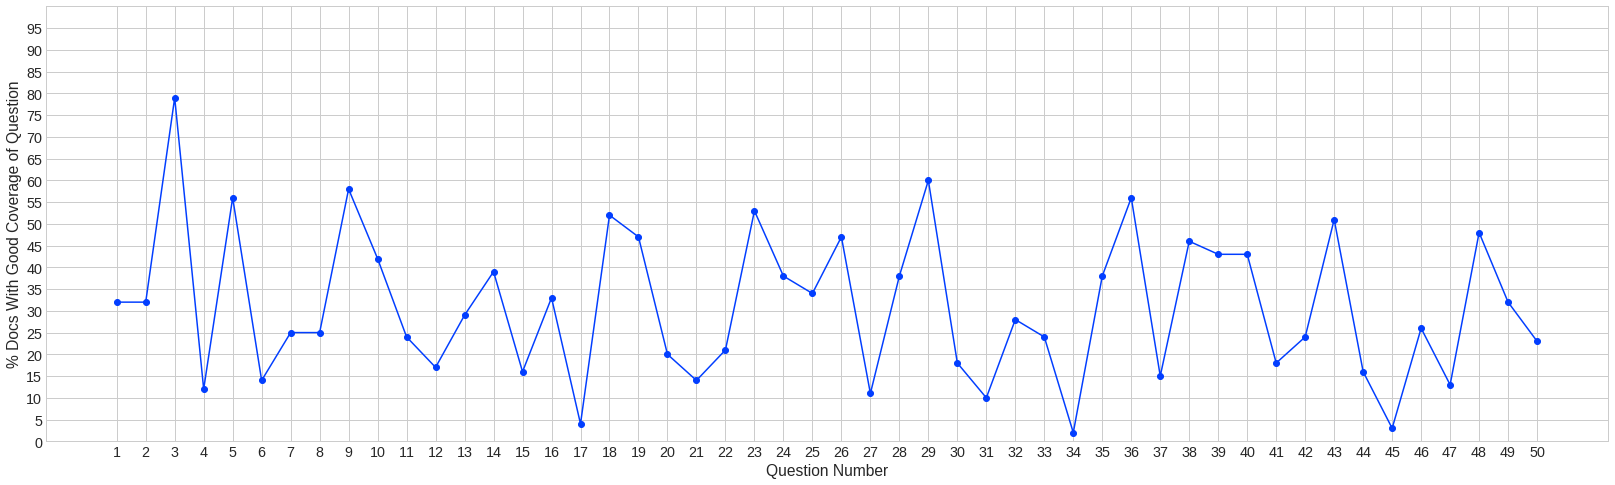

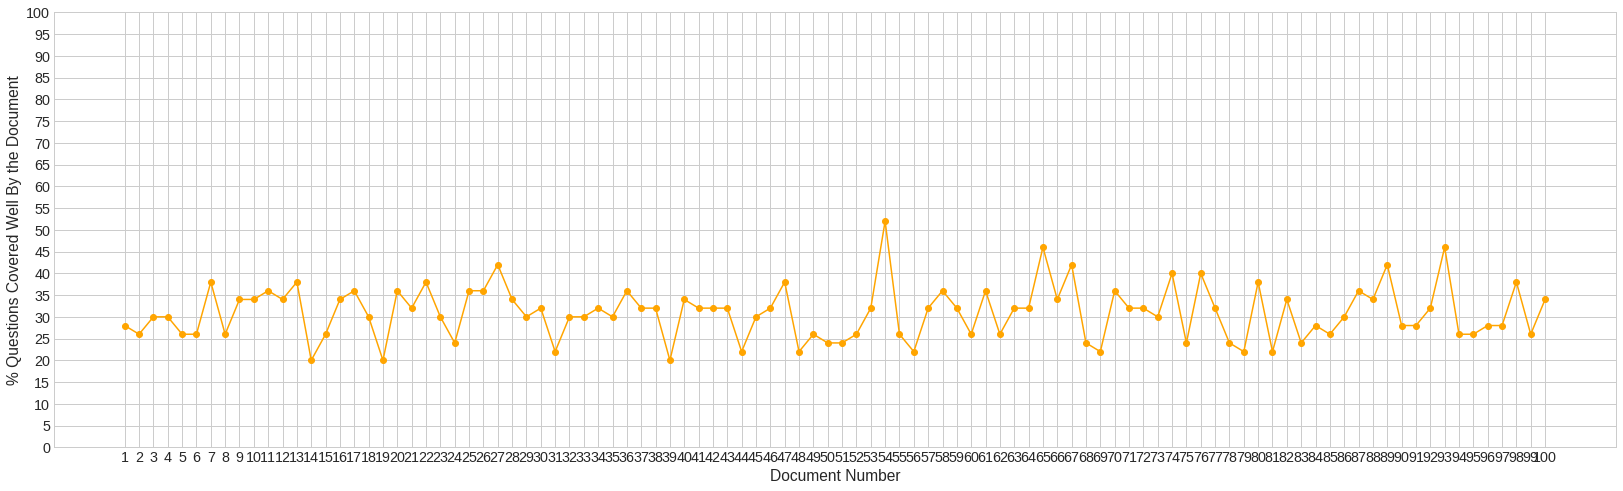

In [203]:
# Use the dict from grid_stats to plot the results
df_out = dict_out['df_out']

# Questions on the x axis with % of documents that cover that question well on the y axis
x_values = [x[1:] for x in df_out.index.values][:-1]
y_values = df_out['% Docs With Good Coverage of Question'].values[:-1]
fig, ax = plt.subplots(figsize=(28,8))
ax.set_ylim([0,100])
ax.set_yticks(list(np.arange(0,100,5)))
ax.set_xlabel("Question Number")
ax.set_ylabel("% Docs With Good Coverage of Question")
plt.plot(x_values, y_values, color='b', marker='o');


# Documents on the x axis with % of questions that are covered well by the document on the y axis
x_values = [x[4:] for x in list(df_out)][:-1]
y_values = df_out.loc[[df_out.index.values[-1]]].values[0][:-1]
fig, ax = plt.subplots(figsize=(28,8))
ax.set_ylim([0,100])
ax.set_yticks(list(np.arange(0,105,5)))
ax.set_xlabel("Document Number")
ax.set_ylabel("% Questions Covered Well By the Document")
plt.plot(x_values, y_values, color='orange', marker='o');

## ROUGH WORK

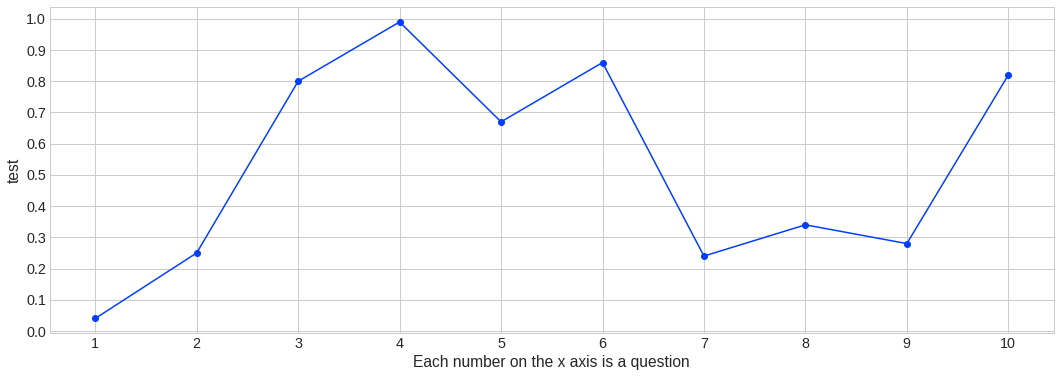

In [72]:
x_values = [x[1:] for x in df_grid.index.values]
y_values = df_grid.iloc[0].values
fig, ax = plt.subplots(figsize=(18,6))
ax.set_yticks(list(np.arange(-0.1,1.5,0.1)))
ax.set_xlabel("Each number on the x axis is a question")
ax.set_ylabel("test")
plt.plot(x_values, y_values, color='b', marker='o')

In [8]:
# Start by generating a random list of reals between 0 and 1
## random.choices works in Python 3.6 and greater
random.choices([0,1], weights=None,cum_weights=None, k=12)

[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]

In [59]:
fit_row = [random.random() for i in range(5)]
fit_row

[0.125294475321169,
 0.4115625129619517,
 0.6828747630165201,
 0.14136476335652293,
 0.6256702823151284]

In [60]:
random.shuffle(fit_row)
fit_row

[0.125294475321169,
 0.6828747630165201,
 0.6256702823151284,
 0.14136476335652293,
 0.4115625129619517]

In [22]:
round(random.uniform(0,.25), 2)

0.11

In [51]:
constrained_sum_sample_pos(4, 100)

[18, 29, 32, 21]

In [24]:
len(dict_ranges)

3

In [31]:
list(dict_ranges.values())[0]

[0, 0.25]

In [52]:
flatten_list([[0.22, 0.12, 0.17, 0.07, 0.15, 0.13, 0.16], [0.44], [0.95, 0.83]])

[0.22, 0.12, 0.17, 0.07, 0.15, 0.13, 0.16, 0.44, 0.95, 0.83]